# Method 7 - Best Ideas Medium Concentration

In [1]:
%matplotlib inline
import pandas as pd
import warnings
from statsmodels import api as sm

from eptooling import crsp, epd, fs, hfu, crsp, db, bi
from eptooling.bm import bmdb, iso
from epquant.engine import weights, portfolio
from epquant.gen import returns
from epquant.perf import relative_performance

warnings.filterwarnings("ignore")

## Fetch Holdings and Benchmark Data

In [2]:
# Get HFU Data

%store -r inst_data
inst_data = inst_data[inst_data['datadate'] >= '1999-06-30']

# Herfindahl

inst_data['target_sq'] = inst_data['target'] ** 2
herf = inst_data.groupby(['datadate', 'institution_id'])['target_sq'].sum().rename('herf').reset_index()

# Count number of positions per manager

inst_data['num_pos'] = inst_data.groupby(['datadate', 'institution_id'])[
    'fsym_id'].transform(lambda s: s.nunique())

# Remove less than 20 holdings and less than $5mm per CSP

valid_data = inst_data[inst_data['num_pos'] >= 20]
valid_data = valid_data[valid_data['public_aum'] >= 5e6]

# Add Expected Returns from Intra-Cap Portfolio Weight per Shumway, Szefler, Yuan 2009

%store -r cap_exp_ret

valid_data = valid_data.merge(cap_exp_ret, on=['datadate', 'institution_id', 'fsym_id'], how='left')

# Calculate CSP Weight per Market Tilt

valid_data['adj_target'] = valid_data['expected_return']

## Calculate Best Ideas

In [3]:
# Extract Best Ideas

valid_data['pos_rank'] = valid_data\
    .groupby(['datadate', 'institution_id'])['adj_target'].rank(ascending=False)

best_ideas = valid_data[valid_data['pos_rank'] == 1].copy()

# Add Herf

best_ideas = best_ideas.merge(herf)
best_ideas['herf_pct'] = best_ideas.groupby('datadate')['herf'].rank(pct=True)
best_ideas = best_ideas[(best_ideas['herf_pct'] > (1 / 3)) & (best_ideas['herf_pct'] < (2 / 3))]

# Weight the best ideas equally

best_ideas['target'] = 1 / best_ideas.groupby('datadate')['institution_id'].transform('count')

## Backtest Portfolio

In [4]:
w = weights.Weights(best_ideas)

%store -r r

p = portfolio.DailyPortfolio(w, r, end_date='2018-12-31')

rf = bi.get_risk_free_rate()
monthly_return = p.port_return.loc['1999-07-01':].resample('M').apply(epd.prod_red)
monthly_return = (monthly_return - rf).dropna()
monthly_return.name = 'port_return'

## Plot Performance

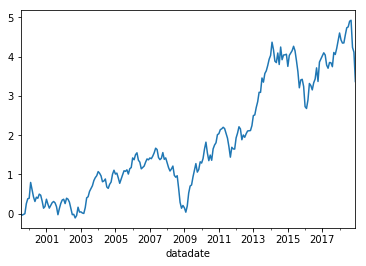

In [5]:
epd.nav(monthly_return).plot()

In [6]:
monthly_return.resample('A').apply(epd.prod_red)

datadate
1999-12-31    0.379897
2000-12-31   -0.142456
2001-12-31    0.139898
2002-12-31   -0.228759
2003-12-31    0.890796
2004-12-31    0.071148
2005-12-31    0.032415
2006-12-31    0.090545
2007-12-31    0.020716
2008-12-31   -0.500526
2009-12-31    0.920188
2010-12-31    0.297322
2011-12-31   -0.121868
2012-12-31    0.225775
2013-12-31    0.522053
2014-12-31    0.025631
2015-12-31   -0.162500
2016-12-31    0.165355
2017-12-31    0.094603
2018-12-31   -0.192588
Freq: A-DEC, Name: port_return, dtype: float64

## Fetch Factor Models

In [7]:
# Get Factor Models
q_factor_model = bi.get_q_factor_model()
fama_french_five_factor_model = bi.get_fama_french_five_factor_model()
four_factor_model = bi.get_four_factor_model()

# Concat Portfolio Return
q_factor = pd.concat([monthly_return, q_factor_model], axis=1)
fama_french_five = pd.concat([monthly_return, fama_french_five_factor_model], axis=1)
four_factor = pd.concat([monthly_return, four_factor_model], axis=1)

# Add Constants
q_factor.insert(1, 'const', 1)
fama_french_five.insert(1, 'const', 1)
four_factor.insert(1, 'const', 1)

# Split Period into Pre and Post Crisis
q_factor_pre, q_factor_post = q_factor.loc[:'2009-06-30'], q_factor.loc['2009-07-31':]
fama_french_five_pre, fama_french_five_post = fama_french_five.loc[:'2009-06-30'], fama_french_five.loc['2009-07-31':] 
four_factor_pre, four_factor_post = four_factor.loc[:'2009-06-30'], four_factor.loc['2009-07-31':] 

## Full Time Period Regressions

### Q Factor Model

In [8]:
sm.OLS(q_factor.iloc[:, :1], q_factor.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.884
Model:                            OLS   Adj. R-squared:                  0.882
Method:                 Least Squares   F-statistic:                     435.4
Date:                Mon, 27 Apr 2020   Prob (F-statistic):          9.61e-106
Time:                        21:28:01   Log-Likelihood:                 528.67
No. Observations:                 234   AIC:                            -1047.
Df Residuals:                     229   BIC:                            -1030.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0051      0.002      2.917      0.004       0.002       0.009
mktrf          0.9283      0.048     19.486      0.000       0.834       1.022
me             0.7443      0.055     13.432      0.000       0.635       0.854
ia             0.1041      0.084      1.237      0.217      -0.062       0.270
roe           -0.7949      0.072    -11.026      0.000      -0.937      -0.653
==============================================================================
Omnibus:                       75.879   Durbin-Watson:                   1.903
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              464.145
Skew:                           1.110   Prob(JB):                    1.63e-101
Kurtosis:                       9.533   Cond. No.                         53.0
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Q Factor Model - Newey West (9 Lag)

In [9]:
sm.OLS(q_factor.iloc[:, :1], q_factor.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.884
Model:                            OLS   Adj. R-squared:                  0.882
Method:                 Least Squares   F-statistic:                     398.1
Date:                Mon, 27 Apr 2020   Prob (F-statistic):          7.67e-102
Time:                        21:28:01   Log-Likelihood:                 528.67
No. Observations:                 234   AIC:                            -1047.
Df Residuals:                     229   BIC:                            -1030.
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0051      0.002      2.645      0.008       0.001       0.009
mktrf          0.9283      0.039     23.564      0.000       0.851       1.005
me             0.7443      0.073     10.181      0.000       0.601       0.888
ia             0.1041      0.119      0.873      0.383      -0.130       0.338
roe           -0.7949      0.110     -7.194      0.000      -1.011      -0.578
==============================================================================
Omnibus:                       75.879   Durbin-Watson:                   1.903
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              464.145
Skew:                           1.110   Prob(JB):                    1.63e-101
Kurtosis:                       9.533   Cond. No.                         53.0
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Q Factor Model - Newey West (18 Lag)

In [10]:
sm.OLS(q_factor.iloc[:, :1], q_factor.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.884
Model:                            OLS   Adj. R-squared:                  0.882
Method:                 Least Squares   F-statistic:                     419.3
Date:                Mon, 27 Apr 2020   Prob (F-statistic):          4.21e-104
Time:                        21:28:01   Log-Likelihood:                 528.67
No. Observations:                 234   AIC:                            -1047.
Df Residuals:                     229   BIC:                            -1030.
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0051      0.002      2.643      0.008       0.001       0.009
mktrf          0.9283      0.041     22.846      0.000       0.849       1.008
me             0.7443      0.078      9.538      0.000       0.591       0.897
ia             0.1041      0.107      0.969      0.333      -0.106       0.315
roe           -0.7949      0.121     -6.595      0.000      -1.031      -0.559
==============================================================================
Omnibus:                       75.879   Durbin-Watson:                   1.903
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              464.145
Skew:                           1.110   Prob(JB):                    1.63e-101
Kurtosis:                       9.533   Cond. No.                         53.0
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

### Fama French Five Factor Model

In [11]:
sm.OLS(fama_french_five.iloc[:, :1], fama_french_five.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.860
Model:                            OLS   Adj. R-squared:                  0.857
Method:                 Least Squares   F-statistic:                     280.4
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           3.12e-95
Time:                        21:28:01   Log-Likelihood:                 506.98
No. Observations:                 234   AIC:                            -1002.
Df Residuals:                     228   BIC:                            -981.2
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0036      0.002      1.868      0.063      -0.000       0.007
mktrf          1.0605      0.052     20.205      0.000       0.957       1.164
smb            0.8090      0.069     11.682      0.000       0.673       0.945
hml            0.0177      0.082      0.216      0.829      -0.143       0.179
rmw           -0.5739      0.092     -6.216      0.000      -0.756      -0.392
cma            0.2172      0.117      1.851      0.066      -0.014       0.448
==============================================================================
Omnibus:                       70.020   Durbin-Watson:                   1.901
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              276.682
Skew:                           1.163   Prob(JB):                     8.30e-61
Kurtosis:                       7.792   Cond. No.                         72.5
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Fama French Five Factor Model - Newey West (9 Lag)

In [12]:
sm.OLS(fama_french_five.iloc[:, :1], fama_french_five.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.860
Model:                            OLS   Adj. R-squared:                  0.857
Method:                 Least Squares   F-statistic:                     162.2
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           5.12e-73
Time:                        21:28:01   Log-Likelihood:                 506.98
No. Observations:                 234   AIC:                            -1002.
Df Residuals:                     228   BIC:                            -981.2
Df Model:                           5                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0036      0.002      1.780      0.075      -0.000       0.008
mktrf          1.0605      0.052     20.296      0.000       0.958       1.163
smb            0.8090      0.080     10.129      0.000       0.652       0.966
hml            0.0177      0.124      0.143      0.886      -0.225       0.260
rmw           -0.5739      0.120     -4.803      0.000      -0.808      -0.340
cma            0.2172      0.152      1.432      0.152      -0.080       0.514
==============================================================================
Omnibus:                       70.020   Durbin-Watson:                   1.901
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              276.682
Skew:                           1.163   Prob(JB):                     8.30e-61
Kurtosis:                       7.792   Cond. No.                         72.5
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Fama French Five Factor Model - Newey West (18 Lag)

In [13]:
sm.OLS(fama_french_five.iloc[:, :1], fama_french_five.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.860
Model:                            OLS   Adj. R-squared:                  0.857
Method:                 Least Squares   F-statistic:                     191.1
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           1.94e-79
Time:                        21:28:01   Log-Likelihood:                 506.98
No. Observations:                 234   AIC:                            -1002.
Df Residuals:                     228   BIC:                            -981.2
Df Model:                           5                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0036      0.002      1.733      0.083      -0.000       0.008
mktrf          1.0605      0.057     18.490      0.000       0.948       1.173
smb            0.8090      0.072     11.168      0.000       0.667       0.951
hml            0.0177      0.107      0.165      0.869      -0.192       0.228
rmw           -0.5739      0.132     -4.347      0.000      -0.833      -0.315
cma            0.2172      0.146      1.491      0.136      -0.068       0.503
==============================================================================
Omnibus:                       70.020   Durbin-Watson:                   1.901
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              276.682
Skew:                           1.163   Prob(JB):                     8.30e-61
Kurtosis:                       7.792   Cond. No.                         72.5
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

### Carhart Four Factor Model

In [14]:
sm.OLS(four_factor.iloc[:, :1], four_factor.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.856
Model:                            OLS   Adj. R-squared:                  0.853
Method:                 Least Squares   F-statistic:                     339.3
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           5.72e-95
Time:                        21:28:01   Log-Likelihood:                 503.29
No. Observations:                 234   AIC:                            -996.6
Df Residuals:                     229   BIC:                            -979.3
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0026      0.002      1.396      0.164      -0.001       0.006
mktrf          1.0668      0.049     21.822      0.000       0.970       1.163
smb            1.0642      0.061     17.439      0.000       0.944       1.184
hml            0.0529      0.061      0.872      0.384      -0.067       0.172
umd           -0.2407      0.040     -6.051      0.000      -0.319      -0.162
==============================================================================
Omnibus:                       46.398   Durbin-Watson:                   1.901
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              163.418
Skew:                           0.766   Prob(JB):                     3.27e-36
Kurtosis:                       6.797   Cond. No.                         36.8
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Carhart Four Factor Model - Newey West (9 Lag)

In [15]:
sm.OLS(four_factor.iloc[:, :1], four_factor.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.856
Model:                            OLS   Adj. R-squared:                  0.853
Method:                 Least Squares   F-statistic:                     263.6
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           1.86e-84
Time:                        21:28:01   Log-Likelihood:                 503.29
No. Observations:                 234   AIC:                            -996.6
Df Residuals:                     229   BIC:                            -979.3
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0026      0.002      1.316      0.188      -0.001       0.007
mktrf          1.0668      0.041     26.296      0.000       0.987       1.146
smb            1.0642      0.083     12.844      0.000       0.902       1.227
hml            0.0529      0.107      0.496      0.620      -0.156       0.262
umd           -0.2407      0.070     -3.447      0.001      -0.378      -0.104
==============================================================================
Omnibus:                       46.398   Durbin-Watson:                   1.901
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              163.418
Skew:                           0.766   Prob(JB):                     3.27e-36
Kurtosis:                       6.797   Cond. No.                         36.8
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Carhart Four Factor Model - Newey West (18 Lag)

In [16]:
sm.OLS(four_factor.iloc[:, :1], four_factor.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.856
Model:                            OLS   Adj. R-squared:                  0.853
Method:                 Least Squares   F-statistic:                     244.6
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           1.97e-81
Time:                        21:28:01   Log-Likelihood:                 503.29
No. Observations:                 234   AIC:                            -996.6
Df Residuals:                     229   BIC:                            -979.3
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0026      0.002      1.357      0.175      -0.001       0.006
mktrf          1.0668      0.041     26.157      0.000       0.987       1.147
smb            1.0642      0.080     13.329      0.000       0.908       1.221
hml            0.0529      0.103      0.511      0.609      -0.150       0.256
umd           -0.2407      0.068     -3.520      0.000      -0.375      -0.107
==============================================================================
Omnibus:                       46.398   Durbin-Watson:                   1.901
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              163.418
Skew:                           0.766   Prob(JB):                     3.27e-36
Kurtosis:                       6.797   Cond. No.                         36.8
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

## Pre-Crisis Regressions

### Q Factor Model

In [17]:
sm.OLS(q_factor_pre.iloc[:, :1], q_factor_pre.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.883
Model:                            OLS   Adj. R-squared:                  0.879
Method:                 Least Squares   F-statistic:                     217.1
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           1.32e-52
Time:                        21:28:01   Log-Likelihood:                 249.74
No. Observations:                 120   AIC:                            -489.5
Df Residuals:                     115   BIC:                            -475.5
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0085      0.003      2.899      0.004       0.003       0.014
mktrf          0.9556      0.080     12.020      0.000       0.798       1.113
me             0.7670      0.079      9.768      0.000       0.611       0.923
ia             0.0579      0.123      0.471      0.639      -0.186       0.301
roe           -0.7613      0.109     -6.996      0.000      -0.977      -0.546
==============================================================================
Omnibus:                       36.314   Durbin-Watson:                   1.994
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              130.179
Skew:                           0.995   Prob(JB):                     5.40e-29
Kurtosis:                       7.699   Cond. No.                         47.0
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Q Factor Model - Newey West (9 Lag)

In [18]:
sm.OLS(q_factor_pre.iloc[:, :1], q_factor_pre.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.883
Model:                            OLS   Adj. R-squared:                  0.879
Method:                 Least Squares   F-statistic:                     231.8
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           4.74e-54
Time:                        21:28:01   Log-Likelihood:                 249.74
No. Observations:                 120   AIC:                            -489.5
Df Residuals:                     115   BIC:                            -475.5
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0085      0.003      2.689      0.007       0.002       0.015
mktrf          0.9556      0.061     15.613      0.000       0.836       1.076
me             0.7670      0.097      7.930      0.000       0.577       0.957
ia             0.0579      0.160      0.362      0.717      -0.255       0.371
roe           -0.7613      0.156     -4.878      0.000      -1.067      -0.455
==============================================================================
Omnibus:                       36.314   Durbin-Watson:                   1.994
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              130.179
Skew:                           0.995   Prob(JB):                     5.40e-29
Kurtosis:                       7.699   Cond. No.                         47.0
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Q Factor Model - Newey West (18 Lag)

In [19]:
sm.OLS(q_factor_pre.iloc[:, :1], q_factor_pre.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.883
Model:                            OLS   Adj. R-squared:                  0.879
Method:                 Least Squares   F-statistic:                     267.0
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           3.29e-57
Time:                        21:28:01   Log-Likelihood:                 249.74
No. Observations:                 120   AIC:                            -489.5
Df Residuals:                     115   BIC:                            -475.5
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0085      0.003      2.730      0.006       0.002       0.015
mktrf          0.9556      0.065     14.812      0.000       0.829       1.082
me             0.7670      0.106      7.217      0.000       0.559       0.975
ia             0.0579      0.138      0.419      0.675      -0.213       0.329
roe           -0.7613      0.173     -4.400      0.000      -1.100      -0.422
==============================================================================
Omnibus:                       36.314   Durbin-Watson:                   1.994
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              130.179
Skew:                           0.995   Prob(JB):                     5.40e-29
Kurtosis:                       7.699   Cond. No.                         47.0
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

### Fama French Five Factor Model

In [20]:
sm.OLS(fama_french_five_pre.iloc[:, :1], fama_french_five_pre.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.866
Model:                            OLS   Adj. R-squared:                  0.860
Method:                 Least Squares   F-statistic:                     146.9
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           5.59e-48
Time:                        21:28:01   Log-Likelihood:                 241.39
No. Observations:                 120   AIC:                            -470.8
Df Residuals:                     114   BIC:                            -454.1
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0078      0.003      2.408      0.018       0.001       0.014
mktrf          1.1952      0.090     13.242      0.000       1.016       1.374
smb            0.8765      0.102      8.574      0.000       0.674       1.079
hml           -0.0865      0.125     -0.690      0.491      -0.335       0.162
rmw           -0.4150      0.148     -2.809      0.006      -0.708      -0.122
cma            0.2776      0.162      1.716      0.089      -0.043       0.598
==============================================================================
Omnibus:                       24.619   Durbin-Watson:                   2.080
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               54.472
Skew:                           0.803   Prob(JB):                     1.48e-12
Kurtosis:                       5.884   Cond. No.                         67.9
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Fama French Five Factor Model - Newey West (9 Lag)

In [21]:
sm.OLS(fama_french_five_pre.iloc[:, :1], fama_french_five_pre.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.866
Model:                            OLS   Adj. R-squared:                  0.860
Method:                 Least Squares   F-statistic:                     122.2
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           4.16e-44
Time:                        21:28:02   Log-Likelihood:                 241.39
No. Observations:                 120   AIC:                            -470.8
Df Residuals:                     114   BIC:                            -454.1
Df Model:                           5                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0078      0.003      2.473      0.013       0.002       0.014
mktrf          1.1952      0.076     15.634      0.000       1.045       1.345
smb            0.8765      0.115      7.638      0.000       0.652       1.101
hml           -0.0865      0.182     -0.476      0.634      -0.443       0.270
rmw           -0.4150      0.177     -2.349      0.019      -0.761      -0.069
cma            0.2776      0.171      1.627      0.104      -0.057       0.612
==============================================================================
Omnibus:                       24.619   Durbin-Watson:                   2.080
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               54.472
Skew:                           0.803   Prob(JB):                     1.48e-12
Kurtosis:                       5.884   Cond. No.                         67.9
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Fama French Five Factor Model - Newey West (18 Lag)

In [22]:
sm.OLS(fama_french_five_pre.iloc[:, :1], fama_french_five_pre.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.866
Model:                            OLS   Adj. R-squared:                  0.860
Method:                 Least Squares   F-statistic:                     215.7
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           2.23e-56
Time:                        21:28:02   Log-Likelihood:                 241.39
No. Observations:                 120   AIC:                            -470.8
Df Residuals:                     114   BIC:                            -454.1
Df Model:                           5                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0078      0.003      2.449      0.014       0.002       0.014
mktrf          1.1952      0.074     16.227      0.000       1.051       1.340
smb            0.8765      0.101      8.708      0.000       0.679       1.074
hml           -0.0865      0.165     -0.526      0.599      -0.409       0.236
rmw           -0.4150      0.184     -2.258      0.024      -0.775      -0.055
cma            0.2776      0.154      1.799      0.072      -0.025       0.580
==============================================================================
Omnibus:                       24.619   Durbin-Watson:                   2.080
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               54.472
Skew:                           0.803   Prob(JB):                     1.48e-12
Kurtosis:                       5.884   Cond. No.                         67.9
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

### Carhart Four Factor Model

In [23]:
sm.OLS(four_factor_pre.iloc[:, :1], four_factor_pre.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.868
Model:                            OLS   Adj. R-squared:                  0.864
Method:                 Least Squares   F-statistic:                     189.5
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           1.22e-49
Time:                        21:28:02   Log-Likelihood:                 242.60
No. Observations:                 120   AIC:                            -475.2
Df Residuals:                     115   BIC:                            -461.3
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0069      0.003      2.262      0.026       0.001       0.013
mktrf          1.1368      0.074     15.293      0.000       0.990       1.284
smb            1.1028      0.085     13.030      0.000       0.935       1.270
hml            0.0350      0.085      0.413      0.681      -0.133       0.203
umd           -0.2336      0.052     -4.469      0.000      -0.337      -0.130
==============================================================================
Omnibus:                       18.336   Durbin-Watson:                   2.055
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               44.577
Skew:                           0.534   Prob(JB):                     2.09e-10
Kurtosis:                       5.788   Cond. No.                         33.2
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Carhart Four Factor Model - Newey West (9 Lag)

In [24]:
sm.OLS(four_factor_pre.iloc[:, :1], four_factor_pre.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.868
Model:                            OLS   Adj. R-squared:                  0.864
Method:                 Least Squares   F-statistic:                     174.2
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           7.86e-48
Time:                        21:28:02   Log-Likelihood:                 242.60
No. Observations:                 120   AIC:                            -475.2
Df Residuals:                     115   BIC:                            -461.3
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0069      0.003      2.314      0.021       0.001       0.013
mktrf          1.1368      0.052     21.939      0.000       1.035       1.238
smb            1.1028      0.094     11.740      0.000       0.919       1.287
hml            0.0350      0.153      0.228      0.819      -0.265       0.335
umd           -0.2336      0.077     -3.041      0.002      -0.384      -0.083
==============================================================================
Omnibus:                       18.336   Durbin-Watson:                   2.055
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               44.577
Skew:                           0.534   Prob(JB):                     2.09e-10
Kurtosis:                       5.788   Cond. No.                         33.2
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Carhart Four Factor Model - Newey West (18 Lag)

In [25]:
sm.OLS(four_factor_pre.iloc[:, :1], four_factor_pre.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.868
Model:                            OLS   Adj. R-squared:                  0.864
Method:                 Least Squares   F-statistic:                     192.4
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           5.77e-50
Time:                        21:28:02   Log-Likelihood:                 242.60
No. Observations:                 120   AIC:                            -475.2
Df Residuals:                     115   BIC:                            -461.3
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0069      0.003      2.552      0.011       0.002       0.012
mktrf          1.1368      0.049     23.413      0.000       1.042       1.232
smb            1.1028      0.093     11.852      0.000       0.920       1.285
hml            0.0350      0.158      0.221      0.825      -0.275       0.345
umd           -0.2336      0.071     -3.281      0.001      -0.373      -0.094
==============================================================================
Omnibus:                       18.336   Durbin-Watson:                   2.055
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               44.577
Skew:                           0.534   Prob(JB):                     2.09e-10
Kurtosis:                       5.788   Cond. No.                         33.2
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

## Post-Crisis Regressions

### Q Factor Model

In [26]:
sm.OLS(q_factor_post.iloc[:, :1], q_factor_post.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.899
Model:                            OLS   Adj. R-squared:                  0.895
Method:                 Least Squares   F-statistic:                     242.1
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           2.97e-53
Time:                        21:28:02   Log-Likelihood:                 298.67
No. Observations:                 114   AIC:                            -587.3
Df Residuals:                     109   BIC:                            -573.7
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0011      0.002      0.634      0.527      -0.002       0.005
mktrf          0.9519      0.053     17.971      0.000       0.847       1.057
me             0.6166      0.082      7.540      0.000       0.455       0.779
ia             0.2137      0.113      1.884      0.062      -0.011       0.439
roe           -0.8205      0.100     -8.232      0.000      -1.018      -0.623
==============================================================================
Omnibus:                        1.392   Durbin-Watson:                   1.760
Prob(Omnibus):                  0.499   Jarque-Bera (JB):                0.924
Skew:                           0.034   Prob(JB):                        0.630
Kurtosis:                       3.436   Cond. No.                         67.7
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Q Factor Model - Newey West (9 Lag)

In [27]:
sm.OLS(q_factor_post.iloc[:, :1], q_factor_post.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.899
Model:                            OLS   Adj. R-squared:                  0.895
Method:                 Least Squares   F-statistic:                     274.8
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           5.89e-56
Time:                        21:28:02   Log-Likelihood:                 298.67
No. Observations:                 114   AIC:                            -587.3
Df Residuals:                     109   BIC:                            -573.7
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0011      0.002      0.715      0.475      -0.002       0.004
mktrf          0.9519      0.051     18.794      0.000       0.853       1.051
me             0.6166      0.053     11.710      0.000       0.513       0.720
ia             0.2137      0.113      1.894      0.058      -0.007       0.435
roe           -0.8205      0.104     -7.897      0.000      -1.024      -0.617
==============================================================================
Omnibus:                        1.392   Durbin-Watson:                   1.760
Prob(Omnibus):                  0.499   Jarque-Bera (JB):                0.924
Skew:                           0.034   Prob(JB):                        0.630
Kurtosis:                       3.436   Cond. No.                         67.7
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Q Factor Model - Newey West (18 Lag)

In [28]:
sm.OLS(q_factor_post.iloc[:, :1], q_factor_post.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.899
Model:                            OLS   Adj. R-squared:                  0.895
Method:                 Least Squares   F-statistic:                     299.7
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           7.92e-58
Time:                        21:28:02   Log-Likelihood:                 298.67
No. Observations:                 114   AIC:                            -587.3
Df Residuals:                     109   BIC:                            -573.7
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0011      0.001      0.805      0.421      -0.002       0.004
mktrf          0.9519      0.049     19.615      0.000       0.857       1.047
me             0.6166      0.047     13.199      0.000       0.525       0.708
ia             0.2137      0.131      1.638      0.102      -0.042       0.470
roe           -0.8205      0.091     -9.043      0.000      -0.998      -0.643
==============================================================================
Omnibus:                        1.392   Durbin-Watson:                   1.760
Prob(Omnibus):                  0.499   Jarque-Bera (JB):                0.924
Skew:                           0.034   Prob(JB):                        0.630
Kurtosis:                       3.436   Cond. No.                         67.7
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

### Fama French Five Factor Model

In [29]:
sm.OLS(fama_french_five_post.iloc[:, :1], fama_french_five_post.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.878
Model:                            OLS   Adj. R-squared:                  0.873
Method:                 Least Squares   F-statistic:                     156.0
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           9.81e-48
Time:                        21:28:02   Log-Likelihood:                 288.19
No. Observations:                 114   AIC:                            -564.4
Df Residuals:                     108   BIC:                            -548.0
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0009      0.002     -0.466      0.642      -0.005       0.003
mktrf          1.0016      0.056     18.002      0.000       0.891       1.112
smb            0.6593      0.090      7.299      0.000       0.480       0.838
hml            0.0906      0.115      0.786      0.433      -0.138       0.319
rmw           -0.6816      0.141     -4.832      0.000      -0.961      -0.402
cma            0.2141      0.179      1.195      0.235      -0.141       0.569
==============================================================================
Omnibus:                        3.867   Durbin-Watson:                   1.864
Prob(Omnibus):                  0.145   Jarque-Bera (JB):                3.333
Skew:                           0.313   Prob(JB):                        0.189
Kurtosis:                       3.557   Cond. No.                         109.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Fama French Five Factor Model - Newey West (9 Lag)

In [30]:
sm.OLS(fama_french_five_post.iloc[:, :1], fama_french_five_post.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.878
Model:                            OLS   Adj. R-squared:                  0.873
Method:                 Least Squares   F-statistic:                     101.9
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           2.94e-39
Time:                        21:28:02   Log-Likelihood:                 288.19
No. Observations:                 114   AIC:                            -564.4
Df Residuals:                     108   BIC:                            -548.0
Df Model:                           5                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0009      0.002     -0.444      0.657      -0.005       0.003
mktrf          1.0016      0.058     17.366      0.000       0.889       1.115
smb            0.6593      0.073      8.987      0.000       0.516       0.803
hml            0.0906      0.090      1.001      0.317      -0.087       0.268
rmw           -0.6816      0.210     -3.241      0.001      -1.094      -0.269
cma            0.2141      0.162      1.324      0.185      -0.103       0.531
==============================================================================
Omnibus:                        3.867   Durbin-Watson:                   1.864
Prob(Omnibus):                  0.145   Jarque-Bera (JB):                3.333
Skew:                           0.313   Prob(JB):                        0.189
Kurtosis:                       3.557   Cond. No.                         109.
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Fama French Five Factor Model - Newey West (18 Lag)

In [31]:
sm.OLS(fama_french_five_post.iloc[:, :1], fama_french_five_post.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.878
Model:                            OLS   Adj. R-squared:                  0.873
Method:                 Least Squares   F-statistic:                     121.2
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           1.22e-42
Time:                        21:28:02   Log-Likelihood:                 288.19
No. Observations:                 114   AIC:                            -564.4
Df Residuals:                     108   BIC:                            -548.0
Df Model:                           5                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0009      0.002     -0.455      0.649      -0.005       0.003
mktrf          1.0016      0.061     16.344      0.000       0.881       1.122
smb            0.6593      0.075      8.794      0.000       0.512       0.806
hml            0.0906      0.092      0.984      0.325      -0.090       0.271
rmw           -0.6816      0.232     -2.942      0.003      -1.136      -0.227
cma            0.2141      0.189      1.130      0.258      -0.157       0.585
==============================================================================
Omnibus:                        3.867   Durbin-Watson:                   1.864
Prob(Omnibus):                  0.145   Jarque-Bera (JB):                3.333
Skew:                           0.313   Prob(JB):                        0.189
Kurtosis:                       3.557   Cond. No.                         109.
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

### Carhart Four Factor Model

In [32]:
sm.OLS(four_factor_post.iloc[:, :1], four_factor_post.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.858
Model:                            OLS   Adj. R-squared:                  0.853
Method:                 Least Squares   F-statistic:                     164.4
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           3.24e-45
Time:                        21:28:02   Log-Likelihood:                 279.27
No. Observations:                 114   AIC:                            -548.5
Df Residuals:                     109   BIC:                            -534.9
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0014      0.002     -0.644      0.521      -0.006       0.003
mktrf          1.0257      0.060     17.234      0.000       0.908       1.144
smb            0.8127      0.093      8.758      0.000       0.629       0.997
hml            0.2385      0.096      2.495      0.014       0.049       0.428
umd           -0.1823      0.072     -2.529      0.013      -0.325      -0.039
==============================================================================
Omnibus:                       10.491   Durbin-Watson:                   1.894
Prob(Omnibus):                  0.005   Jarque-Bera (JB):               15.088
Skew:                           0.448   Prob(JB):                     0.000529
Kurtosis:                       4.540   Cond. No.                         52.2
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Carhart Four Factor Model - Newey West (9 Lag)

In [33]:
sm.OLS(four_factor_post.iloc[:, :1], four_factor_post.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.858
Model:                            OLS   Adj. R-squared:                  0.853
Method:                 Least Squares   F-statistic:                     182.8
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           2.19e-47
Time:                        21:28:02   Log-Likelihood:                 279.27
No. Observations:                 114   AIC:                            -548.5
Df Residuals:                     109   BIC:                            -534.9
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0014      0.002     -0.733      0.464      -0.005       0.002
mktrf          1.0257      0.050     20.422      0.000       0.927       1.124
smb            0.8127      0.093      8.729      0.000       0.630       0.995
hml            0.2385      0.097      2.447      0.014       0.047       0.429
umd           -0.1823      0.044     -4.114      0.000      -0.269      -0.095
==============================================================================
Omnibus:                       10.491   Durbin-Watson:                   1.894
Prob(Omnibus):                  0.005   Jarque-Bera (JB):               15.088
Skew:                           0.448   Prob(JB):                     0.000529
Kurtosis:                       4.540   Cond. No.                         52.2
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Carhart Four Factor Model - Newey West (18 Lag)

In [34]:
sm.OLS(four_factor_post.iloc[:, :1], four_factor_post.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.858
Model:                            OLS   Adj. R-squared:                  0.853
Method:                 Least Squares   F-statistic:                     190.7
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           2.98e-48
Time:                        21:28:02   Log-Likelihood:                 279.27
No. Observations:                 114   AIC:                            -548.5
Df Residuals:                     109   BIC:                            -534.9
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0014      0.002     -0.715      0.474      -0.005       0.002
mktrf          1.0257      0.049     20.915      0.000       0.930       1.122
smb            0.8127      0.080     10.143      0.000       0.656       0.970
hml            0.2385      0.087      2.729      0.006       0.067       0.410
umd           -0.1823      0.036     -5.001      0.000      -0.254      -0.111
==============================================================================
Omnibus:                       10.491   Durbin-Watson:                   1.894
Prob(Omnibus):                  0.005   Jarque-Bera (JB):               15.088
Skew:                           0.448   Prob(JB):                     0.000529
Kurtosis:                       4.540   Cond. No.                         52.2
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""